In [37]:
import numpy as np
from numpy.random import random
from numpy import sqrt, sin,cos, pi, array, dot
import matplotlib.pyplot as plt

import matplotlib
import scipy.stats

import time
from time import perf_counter as clock

from matplotlib import animation, rc
from IPython.display import HTML
import tempfile; tempfile.tempdir='./'

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

## Ideal gas simulator

In [38]:
# modified from https://github.com/vpython/visual/blob/master/examples/gas.py
# converted to 2d, switched to pure numpy functions, visualization using matplotlib instead of vpython

# A model of an ideal gas with hard-sphere collisions
# Program uses Numeric Python arrays for high speed computations
k = 1.4E-23 # Boltzmann constant
Matom = 4E-3/6E23 # helium mass in kg

def simulate_gas(Natoms=1000, Nframes=500,  T=300, L=1, Ratom=0.003,dt=1E-5, start_half=False, start_uneven_energy=False):
# A model of an ideal gas with hard-sphere collisions
# Nframes is number of timesteps of dt to simulate
# T is temperature in K, L is box size in m, Ratom is atom radius in m, dt is timestep in seconds
# Returns poslist_frames -- list of postions of all atoms at each frame
#         plist_frames -- list of corresponding momenta of all atoms at each frame
#         wall_dp_frames -- sum of absolute value of momenta transfer to all 4 walls during each frame
    poslist = []
    plist = []
    mlist = []
    rlist = []

    # initialize the positions of the atoms
    for i in range(Natoms):
        Lmin = 1.1*Ratom
        Lmax = L-Lmin
        if (start_half): # start all of the atoms on the LHS of the box
          x = Lmin+0.5*(Lmax-Lmin)*random()
          y = Lmin+(Lmax-Lmin)*random()
        else:
          x = Lmin+(Lmax-Lmin)*random()
          y = Lmin+(Lmax-Lmin)*random()
    #   z = Lmin+(Lmax-Lmin)*random()
        r = Ratom
        mass = Matom*r**3/Ratom**3 # only would matter if we had different atom sizes
        pavg = sqrt(2.*mass*1.*k*T) # average kinetic energy p**2/(2mass) = (2/2)kT (2d gas)
        phi = 2*pi*random()
        if (start_uneven_energy and i>Natoms/2):
          px = 0
          py = 0
        else:
          px = pavg*cos(phi)
          py = pavg*sin(phi)
    #    pz = pavg*cos(theta)
        poslist.append((x,y))
        plist.append((px,py))
        mlist.append(mass)
        rlist.append(r)

    pos = array(poslist)
    p = array(plist)
    m = array(mlist)
    m.shape = (Natoms,1) # Numeric Python: (1 by Natoms) vs. (Natoms by 1)
    radius = array(rlist)

    t = 0.0
    Nsteps = 0
    pos = pos+(p/m)*(dt/2.) # initial half-step
    time = clock()

    poslist_frames = [pos];
    plist_frames = [p];
    wall_dp_frames = [0];

    while (Nsteps < Nframes):
        # Update all positions
        pos = pos+(p/m)*dt

        r = pos-pos[:,np.newaxis] # all pairs of atom-to-atom vectors
        rmag = sqrt(np.sum(r*r,-1)) # atom-to-atom scalar distances
        hit = np.less_equal(rmag,radius+radius[:,np.newaxis])-np.identity(Natoms)
        hitlist = np.sort(np.nonzero(hit.flatten())).tolist()[0]# i,j encoded as i*Natoms+j    
        # If any collisions took place:

        hitlist_nodups = hitlist
        for ij in hitlist:
            i, j = np.divmod(ij,Natoms) # decode atom pair
            hitlist_nodups.remove(j*Natoms+i) # remove symmetric j,i pair from list

        for ij in hitlist_nodups:
            i, j = np.divmod(ij,Natoms) # decode atom pair
            #print(i,j, np.sqrt(np.sum((pos[i]-pos[j])**2)))
            ptot = p[i]+p[j]
            mi = m[i,0]
            mj = m[j,0]
            vi = p[i]/mi
            vj = p[j]/mj
            ri = radius[i]
            rj = radius[j]
            a = np.linalg.norm(vj-vi)**2
            if a == 0: continue # exactly same velocities
            b = 2*dot(pos[i]-pos[j],vj-vi)
            c = np.linalg.norm(pos[i]-pos[j])**2-(ri+rj)**2
            d = b**2-4.*a*c
            if d < 0: continue # something wrong; ignore this rare case
            deltat = (-b+sqrt(d))/(2.*a) # t-deltat is when they made contact
            pos[i] = pos[i]-(p[i]/mi)*deltat # back up to contact configuration
            pos[j] = pos[j]-(p[j]/mj)*deltat
            mtot = mi+mj
            pcmi = p[i]-ptot*mi/mtot # transform momenta to cm frame
            pcmj = p[j]-ptot*mj/mtot
            rrel = (pos[j]-pos[i])/np.linalg.norm(pos[j]-pos[i])
            #print(pcmi,pcmj, rrel)
            #print(dot(pcmi,rrel))
            pcmi = pcmi-2*dot(pcmi,rrel)*rrel # bounce in cm frame
            pcmj = pcmj-2*dot(pcmj,rrel)*rrel
            #print(pcmi,pcmj)
            #print(p[i],p[j],pos[i],pos[j])
            p[i] = pcmi+ptot*mi/mtot # transform momenta back to lab frame
            p[j] = pcmj+ptot*mj/mtot
            pos[i] = pos[i]+(p[i]/mi)*deltat # move forward deltat in time
            pos[j] = pos[j]+(p[j]/mj)*deltat
            #print(p[i],p[j],pos[i],pos[j])


        # Bounce off walls
        wall_dp = 0

        outside = np.less_equal(pos,Ratom) # walls closest to origin
        p1 = p*outside
        pnew = p-p1+abs(p1)
        wall_dp += np.sum(abs(p - pnew)) #calculate contributions to pressure        
        p = pnew # force p component inward

        outside = np.greater_equal(pos,L-Ratom) # walls farther from origin
        p1 = p*outside
        pnew = p-p1-abs(p1) # force p component inward
        wall_dp += np.sum(abs(p - pnew)) #calculate contributions to pressure        
        p = pnew # force p component inward

        poslist_frames.append(pos) # save the positions for this frame
        wall_dp_frames.append(wall_dp) # save the momentum transfer to the wall
        plist_frames.append(p)

        Nsteps = Nsteps+1
        t = t+dt

        if Nsteps%50==0:
            print('%3.1f seconds for %d steps with %d Atoms' % (clock()-time, Nsteps, Natoms))
    ##    rate(30)

    return poslist_frames, plist_frames, wall_dp_frames

## Simulator animations

You can verify that the simulator is working by creating a movie of it's time updates, no need to write any code here.

In [39]:
# matplotlib jupyter animations based on http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

def animate_gas(poslist_frames,Ratom_anim = 0.003, L_anim = 1):
    # Generate animation
    width = 4 # width of plot in inches

    # set-up figure and ax
    fig, ax = plt.subplots(figsize=(width,width))
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    simgraph = ax.scatter([], [])

    # convert atom size to figure units
    t = ax.transAxes.transform([(0,0), (Ratom_anim,Ratom_anim)])
    Ratom_pts = (t[1,1]-t[0,0]) * 72/fig.dpi
    s_circ = (Ratom_pts * 2)**2

    def init_model():
        ax.set_xlim((0, 1))
        ax.set_ylim((0, 1))
        simgraph = ax.scatter([], [])
        return (simgraph,)

    def animate_model(i):
        ax.clear()
        ax.set_xlim((0, 1))
        ax.set_ylim((0, 1))
        simgraph = ax.scatter(poslist_frames[i][:,0], poslist_frames[i][:,1], s=s_circ)
        return (simgraph,)

    print("here is first frame, when ready may need to click 'fetch additional output' to watch movie:")
    animate_model(1)
    plt.show()

    # run to generate the html5 video of the positions
    # (takes about 30s for 100 frames)
    # click 'Fetch additional output to see'
    anim = animation.FuncAnimation(fig, animate_model, init_func=init_model,
                                  frames=len(poslist_frames), interval=40)
    
    if IN_COLAB: # colab
      return HTML(anim.to_html5_video())
    else: # cocalc
      fname = tempfile.mktemp('.gif')
      print(fname)
      anim.save(fname)
      time.sleep(0.1) # make sure file is saved
      return display(HTML("""
                  <image style="width:200" src="{}" >
                  """.format(fname)))


0.0 seconds for 50 steps with 100 Atoms
0.0 seconds for 100 steps with 100 Atoms
here is first frame, when ready may need to click 'fetch additional output' to watch movie:


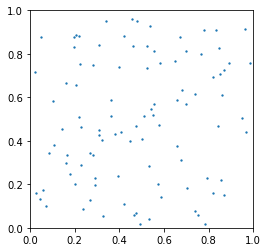

MovieWriter ffmpeg unavailable; using Pillow instead.


./tmp9ymy2jor.gif


In [40]:
# example:

Natoms = 100
Nframes = 100

Ratom = 0.003
L = 1

# Run the model
poslist_frames, plist_frames, wall_dp_frames = simulate_gas(Natoms=Natoms, Nframes=Nframes, Ratom=Ratom, L = L)

animate_gas(poslist_frames[:100], Ratom_anim=Ratom, L_anim = L) # best practice, only visualize 100 frames or movie takes a long time to generate

## Get data from simulation and visualize


In [41]:

# set simulation parameters
Natoms = 500
Nframes = 1000
dt = 1E-5 # s
T=300 # Kelvin
Ratom = 0.003 # meters -- grossly exagerated
L = 1 # meters

# Run the simulator to get data (takes about 1m for 5000 steps with 500 atoms)
poslist_frames, plist_frames, wall_dp_frames = simulate_gas(Natoms=Natoms, Nframes=Nframes, Ratom=Ratom, L = L, dt=dt, T=T, start_half=True)

0.7 seconds for 50 steps with 500 Atoms
1.3 seconds for 100 steps with 500 Atoms
2.0 seconds for 150 steps with 500 Atoms
2.6 seconds for 200 steps with 500 Atoms
3.3 seconds for 250 steps with 500 Atoms
3.9 seconds for 300 steps with 500 Atoms
4.5 seconds for 350 steps with 500 Atoms
5.1 seconds for 400 steps with 500 Atoms
5.7 seconds for 450 steps with 500 Atoms
6.3 seconds for 500 steps with 500 Atoms
6.8 seconds for 550 steps with 500 Atoms
7.4 seconds for 600 steps with 500 Atoms
8.0 seconds for 650 steps with 500 Atoms
8.6 seconds for 700 steps with 500 Atoms
9.2 seconds for 750 steps with 500 Atoms
9.7 seconds for 800 steps with 500 Atoms
10.3 seconds for 850 steps with 500 Atoms
11.1 seconds for 900 steps with 500 Atoms
11.9 seconds for 950 steps with 500 Atoms
12.5 seconds for 1000 steps with 500 Atoms


here is first frame, when ready may need to click 'fetch additional output' to watch movie:


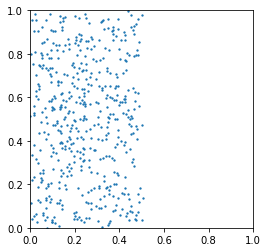

MovieWriter ffmpeg unavailable; using Pillow instead.


./tmpf2m5_loi.gif


In [42]:
# visualize

animate_gas(poslist_frames[:100], Ratom_anim=Ratom, L_anim=L) # first 100 frames, pretty slow to make movie for more

## Energy Coarse-graining (pre-class)

0. Run the simulator with N=500 atoms and 1000 timesteps (frames).

1. Write a function that coarse-grains each configuration of the atoms to just the total energy of all the atoms. Plot this energy as a function of time, and explain its behavior. (Each atom's energy is given by (px^2+py^2)/2m ) 

2. Write a function that takes the first M atoms in the list and coarse-grains them by adding up their energy. Plot the energies as a function of time for M=1,10,100. Explain the differences in behavior.

In [52]:
# set simulation parameters
Natoms = 500
Nframes = 1000
dt = 1E-5 # s
T=300 # Kelvin
Ratom = 0.003 # meters -- grossly exagerated
L = 1 # meters

# Run the simulator to get data (takes about 1m for 5000 steps with 500 atoms)
poslist_frames, plist_frames, wall_dp_frames = simulate_gas(Natoms=Natoms, Nframes=Nframes, Ratom=Ratom, L = L, dt=dt, T=T, start_half=True)

0.6 seconds for 50 steps with 500 Atoms
1.1 seconds for 100 steps with 500 Atoms
1.7 seconds for 150 steps with 500 Atoms
2.2 seconds for 200 steps with 500 Atoms
2.7 seconds for 250 steps with 500 Atoms
3.2 seconds for 300 steps with 500 Atoms
3.8 seconds for 350 steps with 500 Atoms
4.3 seconds for 400 steps with 500 Atoms
4.9 seconds for 450 steps with 500 Atoms
5.5 seconds for 500 steps with 500 Atoms
6.0 seconds for 550 steps with 500 Atoms
6.5 seconds for 600 steps with 500 Atoms
7.1 seconds for 650 steps with 500 Atoms
7.6 seconds for 700 steps with 500 Atoms
8.1 seconds for 750 steps with 500 Atoms
8.7 seconds for 800 steps with 500 Atoms
9.2 seconds for 850 steps with 500 Atoms
9.7 seconds for 900 steps with 500 Atoms
10.3 seconds for 950 steps with 500 Atoms
10.9 seconds for 1000 steps with 500 Atoms


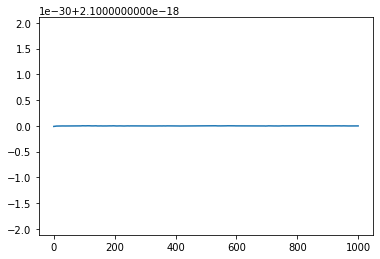

In [53]:
def cg(pl):
    l = []
    for i in pl:
        e = 0
        for j in i:
            e += (j[0]**2 + j[1]**2)/(2*Matom)
        l.append(e)

    return l

plt.plot(range(1001),cg(plist_frames))
plt.show()
            

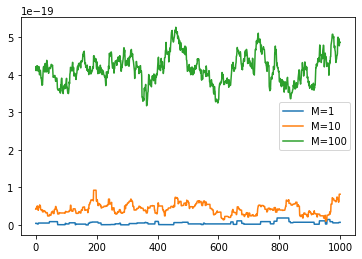

In [51]:
def cgM(pl, M):
    l = []
    for i in pl:
        e = 0
        for j in range(M):
            e += (i[j][0]**2 + i[j][1]**2)/(2*Matom)
        l.append(e)

    return l

plt.plot(range(1001),cgM(plist_frames, 1), label='M=1')
plt.plot(range(1001),cgM(plist_frames, 10), label='M=10')
plt.plot(range(1001),cgM(plist_frames, 100), label='M=100')

plt.legend()
plt.show()